In [1]:
import sys
import os
import time
import shutil
import typing
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
sys.path.append(os.getcwd())
sys.path.append('..')
import chiral_client 
print(f'chiral client version: {chiral_client.version}')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
chiral client version: 0.3.0


# Gromacs Tutorial -  Lysozyme (egg white) in water

## Reference
- [GROMACS Tutorials by Prof. Justin A. Lemkul from Virginia Tech](http://www.mdtutorials.com/gmx/)

In [2]:
def submit_job(client: chiral_client.Client,
    files_upload: typing.List[str], files_input: typing.List[str], files_output: typing.List[str], files_checkpoint: typing.List[str], files_log: typing.List[str],
    args: str, prompts: str,
    data_dir: str
) -> str:
    for filename in files_upload:
        shutil.copy(
            os.path.join(data_dir, filename),
            os.path.join(client.local_dir, client.project, filename)
        )
    client.upload_files(files_upload)

    return client.submit_job_gromacs(args, prompts, files_input, files_output, files_checkpoint, files_log)

def run_step(client: chiral_client.Client,
    files_upload: typing.List[str], files_input: typing.List[str], files_output: typing.List[str], files_checkpoint: typing.List[str], files_log: typing.List[str],
    args: str, prompts: str,
    data_dir: str
):
    job_id = submit_job(client, files_upload, files_input, files_output, files_checkpoint, files_log, args, prompts, data_dir)

    print(f'Job {job_id} created for gromacs command\n {args} with prompts {prompts}')
    client.wait_until_completion(job_id)
    client.download_files(files_output + [f'{job_id}.out', f'{job_id}.err'])
    for filename in files_output:
        assert os.path.exists(os.path.join(client.local_dir, client.project, filename))
    print(f'Job {job_id} completed successfully')

def run_step_1(client: chiral_client.Client, data_dir: str):
    files_upload = ["1AKI_clean.pdb"]
    files_input = files_upload 
    files_output = ["1AKI_processed.gro", "topol.top", "posre.itp"] 
    files_checkpoint = []
    args = 'pdb2gmx -f 1AKI_clean.pdb -o 1AKI_processed.gro -water spce'
    prompts = '15'
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_2(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ["1AKI_processed.gro"]
    files_output = ["1AKI_newbox.gro"] 
    files_checkpoint = []
    args = 'editconf -f 1AKI_processed.gro -o 1AKI_newbox.gro -c -d 1.0 -bt cubic'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_3(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['1AKI_newbox.gro', 'topol.top']
    files_output = ['1AKI_solv.gro', 'topol.top'] 
    files_checkpoint = []
    args = 'solvate -cp 1AKI_newbox.gro -cs spc216.gro -o 1AKI_solv.gro -p topol.top'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_4(client: chiral_client.Client, data_dir: str):
    files_upload = ['ions.mdp']
    files_input = ['ions.mdp', '1AKI_solv.gro', 'topol.top']
    files_output = ['1AKI_solv.gro', 'topol.top', 'ions.tpr'] 
    files_checkpoint = []
    args = 'grompp -f ions.mdp -c 1AKI_solv.gro -p topol.top -o ions.tpr'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_5(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['ions.tpr', 'topol.top']
    files_output = ['1AKI_solv_ions.gro', 'topol.top'] 
    files_checkpoint = []
    args = 'genion -s ions.tpr -o 1AKI_solv_ions.gro -p topol.top -pname NA -nname CL -neutral'
    prompts = '13'
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_6(client: chiral_client.Client, data_dir: str):
    files_upload = ['minim.mdp']
    files_input = ['minim.mdp', '1AKI_solv_ions.gro', 'topol.top']
    files_output = ['em.tpr'] 
    files_checkpoint = []
    args = 'grompp -f minim.mdp -c 1AKI_solv_ions.gro -p topol.top -o em.tpr'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_7(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['em.tpr']
    files_output = ['em.edr', 'em.trr', 'em.gro'] 
    files_checkpoint = []
    files_log = ['em.log']
    args = 'mdrun -deffnm em'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, files_log, args, prompts, data_dir)

def run_step_7_submit(client: chiral_client.Client, data_dir: str) -> str:
    files_upload = []
    files_input = ['em.tpr']
    files_output = ['em.edr', 'em.trr', 'em.gro'] 
    files_checkpoint = []
    files_log = ['em.log']
    args = 'mdrun -deffnm em'
    prompts = ''
    return submit_job(client, files_upload, files_input, files_output, files_checkpoint, files_log, args, prompts, data_dir)

def run_step_8(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['em.edr']
    files_output = ['potential.xvg'] 
    files_checkpoint = []
    args = 'energy -f em.edr -o potential.xvg'
    prompts = '10 0'
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def plot_energy(local_dir: str):
    x,y = np.loadtxt(f'{local_dir}/potential.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x,y)
    plt.title('Energy Minimization')
    plt.xlim((0, 800))
    plt.show()

def run_step_9(client: chiral_client.Client, data_dir: str):
    files_upload = ['nvt.mdp']
    files_input = ['nvt.mdp', 'em.gro', 'topol.top', 'posre.itp']
    files_output = ['nvt.tpr'] 
    files_checkpoint = []
    args = 'grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_10(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['nvt.tpr']
    files_output = ['nvt.log', 'nvt.edr', 'nvt.trr', 'nvt.gro', 'nvt.cpt'] 
    files_checkpoint = []
    files_log = ['nvt.log']
    args = 'mdrun -deffnm nvt'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, files_log, args, prompts, data_dir)

def run_step_11(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['nvt.edr']
    files_output = ['temperature.xvg'] 
    files_checkpoint = []
    args = 'energy -f nvt.edr -o temperature.xvg'
    prompts = '16 0'
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def plot_temperature(local_dir: str):
    x,y = np.loadtxt(f'{local_dir}/temperature.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x,y)
    plt.title('Temperature')
    plt.xlim((0, 100))
    plt.show()

def run_step_12(client: chiral_client.Client, data_dir: str):
    files_upload = ['npt.mdp']
    files_input = ['npt.mdp', 'nvt.gro', 'nvt.cpt', 'topol.top', 'posre.itp']
    files_output = ['npt.tpr'] 
    files_checkpoint = []
    args = 'grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_13(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['npt.tpr']
    files_output = ['npt.log', 'npt.edr', 'npt.trr', 'npt.gro', 'npt.cpt'] 
    files_checkpoint = []
    files_log = ['npt.log']
    args = 'mdrun -deffnm npt'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, files_log, args, prompts, data_dir)

def run_step_14(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['npt.edr']
    files_output = ['pressure.xvg'] 
    files_checkpoint = []
    args = 'energy -f npt.edr -o pressure.xvg'
    prompts = '18 0'
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_15(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['npt.edr']
    files_output = ['density.xvg'] 
    files_checkpoint = []
    args = 'energy -f npt.edr -o density.xvg'
    prompts = '24 0'
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def plot_pressure_density(local_dir: str):
    plt.figure().set_figwidth(10)
    plt.subplot(1, 2, 1) 
    x,y = np.loadtxt(f'{local_dir}/pressure.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x, y)
    plt.title('Pressure')
    plt.suptitle('1AKI NPT Equilibration')
    plt.xlim((0, 100))
    plt.subplot(1, 2, 2) 
    x,y = np.loadtxt(f'{local_dir}/density.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x,y)
    plt.title('Density')
    plt.suptitle('1AKI NPT Equilibration')
    plt.xlim((0, 100))

    plt.show()

def run_step_16(client: chiral_client.Client, data_dir: str):
    files_upload = ['md.mdp']
    files_input = ['md.mdp', 'npt.gro', 'npt.cpt', 'topol.top']
    files_output = ['md_0_1.tpr'] 
    files_checkpoint = []
    args = 'grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md_0_1.tpr'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_17(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['md_0_1.tpr']
    files_output = ['md_0_1.xtc', 'md_0_1.log'] 
    files_checkpoint = []
    files_log = ['md_0_1.log']
    args = 'mdrun -deffnm md_0_1 -nb gpu'
    prompts = ''
    run_step(client, files_upload, files_input, files_output, files_checkpoint, files_log, args, prompts, data_dir)

def run_step_18(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['md_0_1.tpr', 'md_0_1.xtc']
    files_output = ['md_0_1_noPBC.xtc'] 
    files_checkpoint = []
    args = 'trjconv -s md_0_1.tpr -f md_0_1.xtc -o md_0_1_noPBC.xtc -pbc mol -center'
    prompts = '1 0'
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_19(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['md_0_1.tpr', 'md_0_1_noPBC.xtc']
    files_output = ['rmsd.xvg'] 
    files_checkpoint = []
    args = 'rms -s md_0_1.tpr -f md_0_1_noPBC.xtc -o rmsd.xvg -tu ns'
    prompts = '4 4'
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_20(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['em.tpr', 'md_0_1_noPBC.xtc']
    files_output = ['rmsd_xtal.xvg'] 
    files_checkpoint = []
    args = 'rms -s em.tpr -f md_0_1_noPBC.xtc -o rmsd_xtal.xvg -tu ns'
    prompts = '4 4'
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def run_step_21(client: chiral_client.Client, data_dir: str):
    files_upload = []
    files_input = ['md_0_1.tpr', 'md_0_1_noPBC.xtc']
    files_output = ['gyrate.xvg'] 
    files_checkpoint = []
    args = 'gyrate -s md_0_1.tpr -f md_0_1_noPBC.xtc -o gyrate.xvg'
    prompts = '1'
    run_step(client, files_upload, files_input, files_output, files_checkpoint, [], args, prompts, data_dir)

def plot_rmsd_gyration(local_dir: str):
    plt.figure().set_figwidth(10)
    plt.subplot(1, 2, 1) 
    x_1, y_1 = np.loadtxt(f'{local_dir}/rmsd.xvg', comments=['#', '@'], unpack=True)
    x_2, y_2 = np.loadtxt(f'{local_dir}/rmsd_xtal.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x_1, y_1)
    plt.plot(x_2, y_2)
    plt.title('RMSD')
    plt.suptitle('1AKI Backbone')
    plt.xlim((0, 1))
    plt.subplot(1, 2, 2) 
    x_1, y_1, _, _, _ = np.loadtxt(f'{local_dir}/gyrate.xvg', comments=['#', '@'], unpack=True)
    plt.plot(x_1, y_1)
    plt.title('Radius of gyration')
    plt.suptitle('1AKI Unrestrained MD')
    plt.xlim((0, 1))
    plt.show()

user credit points: -4.513
user credit points: -11.136
Job 386cwfm10p5g5dv1kncy4x4xrmdw3592 created for gromacs command
 energy -f em.edr -o potential.xvg with prompts 10 0
Job 386cwfm10p5g5dv1kncy4x4xrmdw3592 completed successfully


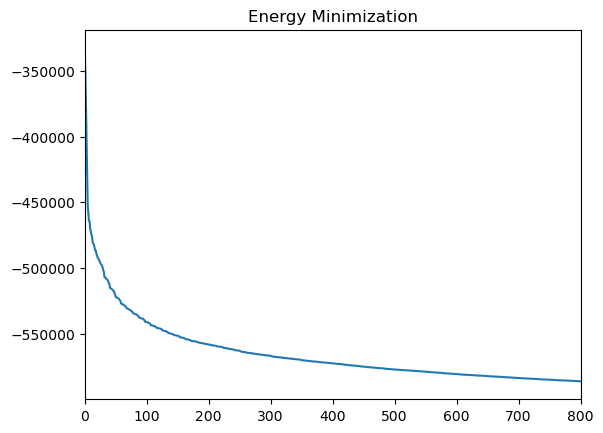

Job tfzkw6e19ke2ikxrmhnomdhllxxxo5sl created for gromacs command
 grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr with prompts 
Job tfzkw6e19ke2ikxrmhnomdhllxxxo5sl completed successfully
Job v1ob8nd8hiwv5kvchjii7v9ji91c59um created for gromacs command
 mdrun -deffnm nvt with prompts 


In [ ]:
# register a user at cloud.chiral.one, get the token api from the page "Profile"
#
user_email = os.environ['CHIRAL_USER_EMAIL']
token_api = os.environ['CHIRAL_TOKEN_API']
chiral_computing_url = os.environ['CHIRAL_CLOUD_URL']
remote_dir = 'gromacs'
local_dir = 'test_gromacs'
client = chiral_client.Client(user_email, token_api, remote_dir, local_dir, chiral_computing_url)

project = 'lysozyme'
if os.path.exists(local_dir):
    shutil.rmtree(local_dir)
os.mkdir(local_dir)
os.mkdir(os.path.join(local_dir, project))
client.set_project(project)
client.create_project_remote()
data_dir = f'./data/gromacs/{project}'

print(f'user credit points: {client.check_credit_points():.3f}')
run_step_1(client, data_dir)
print(f'user credit points: {client.check_credit_points():.3f}')
run_step_2(client, data_dir)
print(f'user credit points: {client.check_credit_points():.3f}')
run_step_3(client, data_dir)
print(f'user credit points: {client.check_credit_points():.3f}')
run_step_4(client, data_dir)
print(f'user credit points: {client.check_credit_points():.3f}')
run_step_5(client, data_dir)
print(f'user credit points: {client.check_credit_points():.3f}')
run_step_6(client, data_dir)
print(f'user credit points: {client.check_credit_points():.3f}')
job_id = run_step_7_submit(client, data_dir)
time.sleep(1)
client.cancel_job(job_id)
print(f'job {job_id} cancelled suclientessfully')
print(f'user credit points: {client.check_credit_points():.3f}')
job_id = run_step_7_submit(client, data_dir)
for idx in range(5):
    time.sleep(2)
    client.request_log_files(job_id)
    print(f'{idx} check log files for job {job_id}')
print(f'user credit points: {client.check_credit_points():.3f}')
client.cancel_job(job_id)
print(f'user credit points: {client.check_credit_points():.3f}')
run_step_7(client, data_dir)
clear_output(wait=True)
print(f'user credit points: {client.check_credit_points():.3f}')
time.sleep(2)
print(f'user credit points: {client.check_credit_points():.3f}')
run_step_8(client, data_dir)
plot_energy(os.path.join(local_dir, client.project))
run_step_9(client, data_dir)
run_step_10(client, data_dir)
clear_output(wait=True)
print(f'user credit points: {client.check_credit_points():.3f}')
run_step_11(client, data_dir)
plot_temperature(os.path.join(local_dir, client.project))
run_step_12(client, data_dir)
run_step_13(client, data_dir)
clear_output(wait=True)
print(f'user credit points: {client.check_credit_points():.3f}')
run_step_14(client, data_dir)
run_step_15(client, data_dir)
plot_pressure_density(os.path.join(local_dir, client.project))
run_step_16(client, data_dir)
run_step_17(client, data_dir)
run_step_18(client, data_dir)
run_step_19(client, data_dir)
clear_output(wait=True)
print(f'user credit points: {client.check_credit_points():.3f}')
run_step_20(client, data_dir)
run_step_21(client, data_dir)
plot_rmsd_gyration(os.path.join(local_dir, client.project))

shutil.rmtree(local_dir)
print(f'Simulation {project} Completes!')
client.remove_remote_dir('.', 'gromacs')
